In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from math import pi
from matplotlib.gridspec import GridSpec

In [2]:
olympics_data = pd.read_csv('../Data/athlete_events.csv')
results_data = pd.read_csv('../Data/results.csv')
NOC_data = pd.read_csv('../Data/noc_regions.csv')

#rimozione delle competizioni artistiche dal dataset
olympics_data = olympics_data[olympics_data['Sport'] != 'Art Competitions']



#ricodifica degli anni dei Giochi Olimpici invernali post-1992
#per abbinarle ai Giochi Olimpici estivi successivi
original = [1994, 1998, 2002, 2006, 2010, 2014]
new = [1996, 2000, 2004, 2008, 2012, 2016]
for orig, new_year in zip(original, new):
    olympics_data['Year'] = olympics_data['Year'].replace(orig, new_year)

# Top 5 nazioni in atletica ginnastica e nuoto

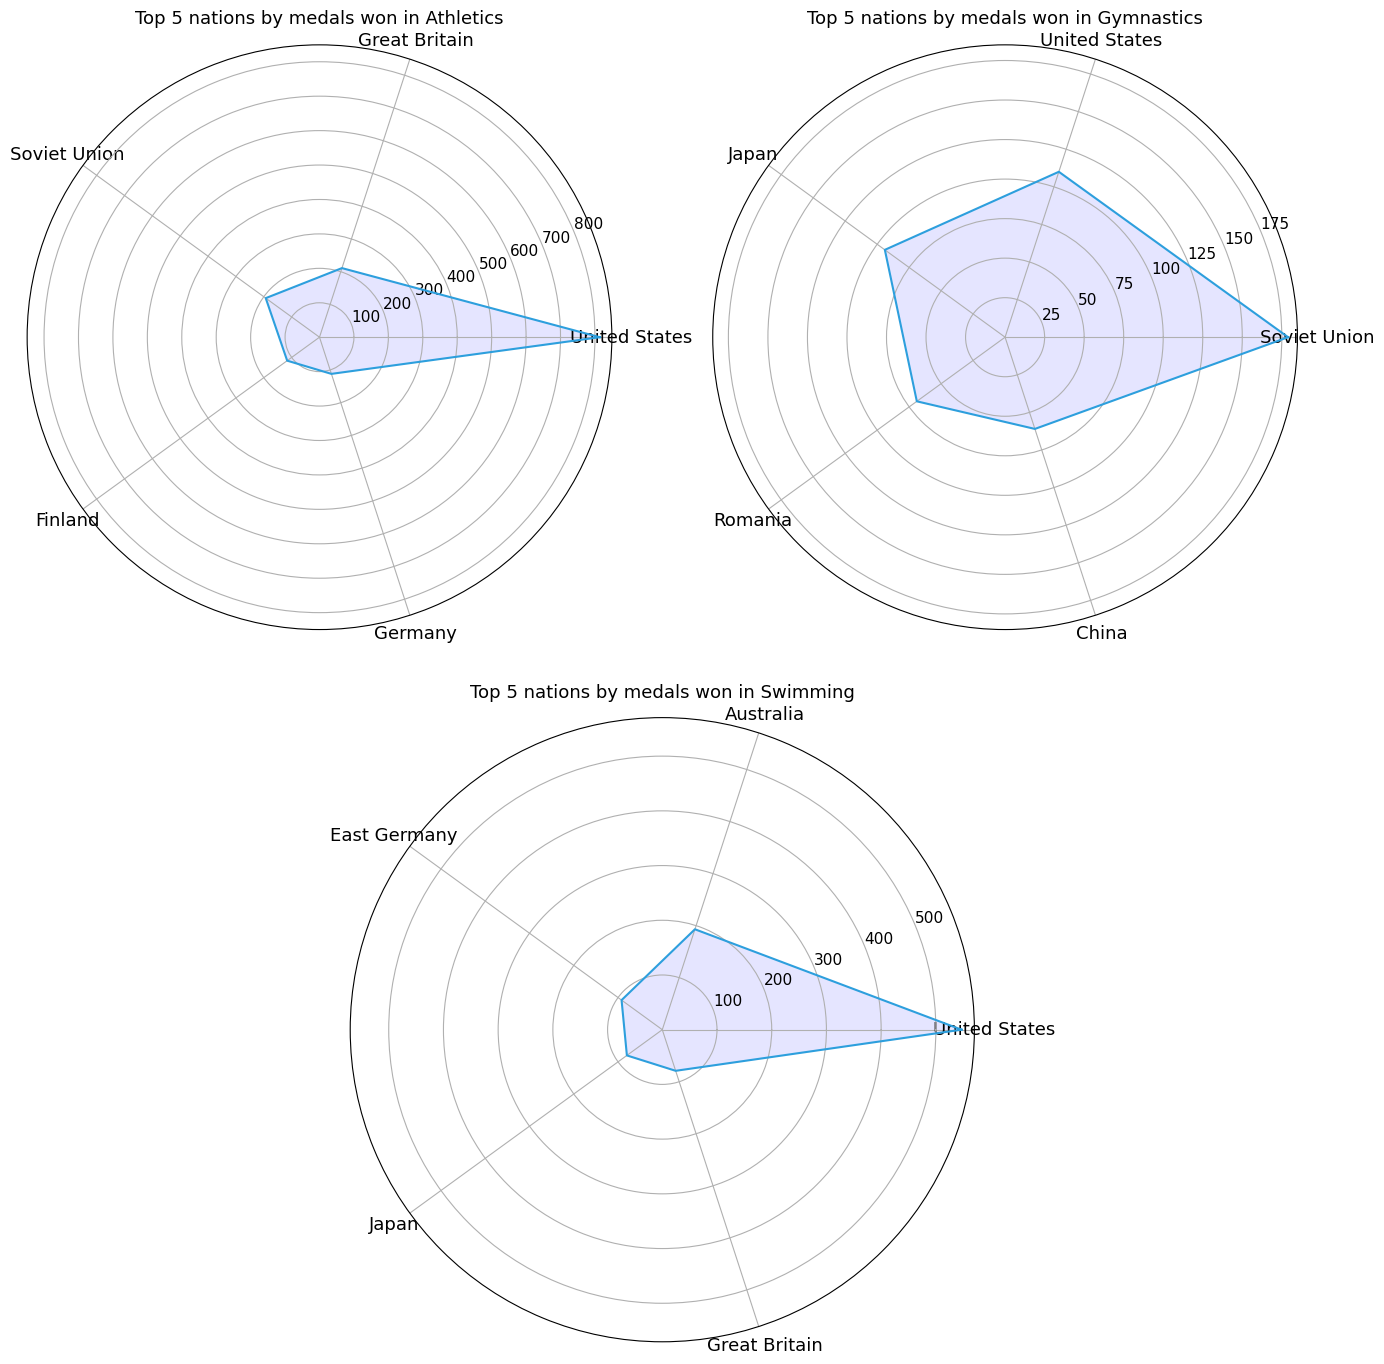

In [4]:
#funzione per preparare i dati e creare i grafici a radar
def create_radar_chart(df, sport, ax, title):
    #filtro dei dati per lo sport specifico
    df_sport = df[df['Sport'] == sport]

    #raggruppamento per nazione e conteggio del numero di medaglie
    medal_counts = df_sport.groupby('Team')['Medal'].count()

    #selezione delle prime 5 nazioni
    top_teams = medal_counts.nlargest(5)

    categories = top_teams.index
    values = top_teams.values

    values = np.append(values, values[0])
    N = len(categories)

    #creazione degli angoli per ogni asse
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]


    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=13)

    ax.plot(angles, values, color='#2d9fdd')
    ax.fill(angles, values, 'b', alpha=0.1)
    ax.set_title(title, fontsize=13)

    ax.tick_params(axis='y', labelsize=11) 

df = olympics_data.dropna(subset=['Medal'])

df = df[['NOC', 'Games', 'Event', 'Sport', 'Team', 'Medal']]

df = df.drop_duplicates(subset=['NOC', 'Games', 'Event', 'Sport', 'Team', 'Medal'])


#creazione dei subplot per affiancare i grafici
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(2, 2, height_ratios=[1, 1])

#grafico a radar per "Athletics"
ax1 = fig.add_subplot(gs[0, 0], polar=True)
create_radar_chart(df, 'Athletics', ax1, 'Top 5 nations by medals won in Athletics')

#grafico a radar per "Swimming"
ax2 = fig.add_subplot(gs[0, 1], polar=True)
create_radar_chart(df, 'Gymnastics', ax2, 'Top 5 nations by medals won in Gymnastics')

#grafico a radar per "Gymnastics"
ax3 = fig.add_subplot(gs[1, :], polar=True)
create_radar_chart(df, 'Swimming', ax3, 'Top 5 nations by medals won in Swimming')

plt.tight_layout()
plt.show()


# Top 30 atleti per medaglie vinte

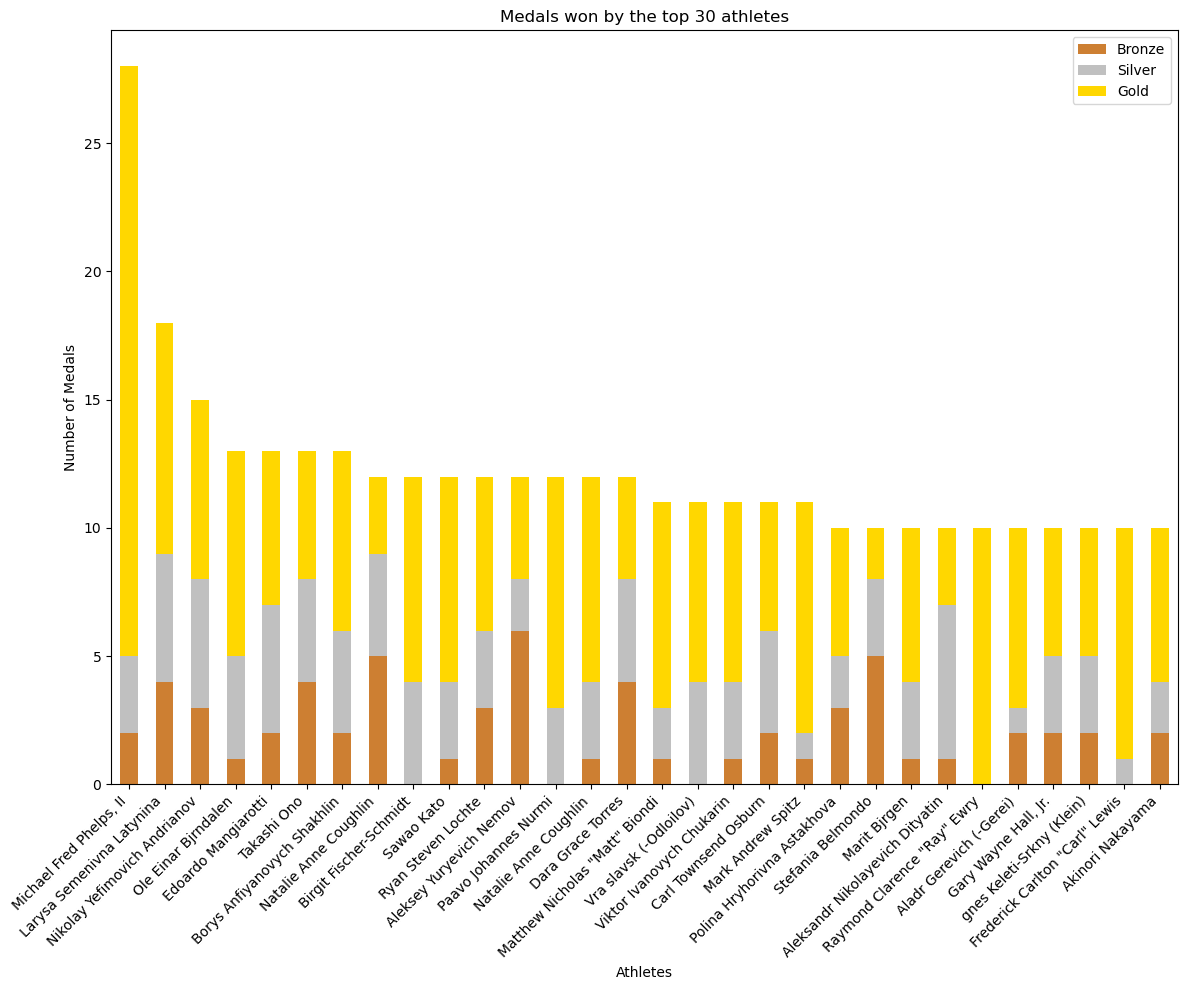

In [6]:
#calcolo del numero di medaglie per ogni ID atleta
medals_count = olympics_data.groupby(['ID', 'Medal']).size().unstack(fill_value=0)

#calcolo del totale medaglie per ogni ID
medals_count['Total'] = medals_count.sum(axis=1)

#selezione dei primi 30 atleti per numero di medaglie totali
top_30_ids = medals_count['Total'].nlargest(30).index

top_30_data = medals_count.loc[top_30_ids, ['Bronze', 'Silver', 'Gold']]
top_30_names = olympics_data[olympics_data['ID'].isin(top_30_ids)][['ID', 'Name']].drop_duplicates().set_index('ID').loc[top_30_ids, 'Name']

colors = ['#CD7F32', '#C0C0C0', '#FFD700']  # bronzo, argento, oro

#creazione del grafico a barre impilate
fig, ax = plt.subplots(figsize=(12, 10))
top_30_data.plot(kind='bar', stacked=True, color=colors, ax=ax)

ax.set_title('Medals won by the top 30 athletes')
ax.set_xlabel('Athletes')
ax.set_ylabel('Number of Medals')
ax.set_xticklabels(top_30_names, rotation=45, ha='right')
ax.legend(['Bronze', 'Silver', 'Gold'], loc='upper right')

plt.tight_layout()
plt.show()

# Distribuzione di medaglie per genere (1896 - 1956 - 2016)

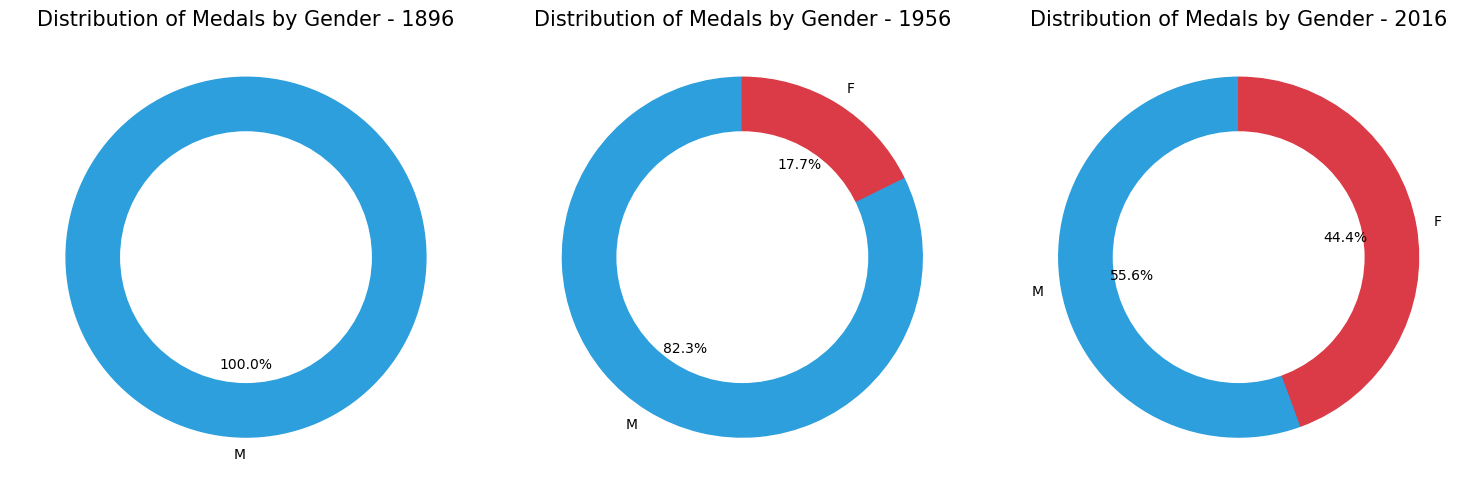

In [8]:
#filtra i dati per gli anni 1896, 1956 e 2016.
years = [1896, 1956, 2016]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#crea un grafico a torta per genere per ciascuno degli anni
for i, year in enumerate(years):

    data_year = olympics_data[olympics_data['Year'] == year]
    
    medals_per_gender = data_year['Sex'].value_counts()
    
    #genera il subplot per l'anno corrente
    ax = axs[i]
    
    #genera il grafico a torta
    wedges, texts, autotexts = ax.pie(medals_per_gender, labels=medals_per_gender.index, autopct='%1.1f%%', startangle=90)
    colors = ['#2d9fdd', '#da3b46']
    for j, wedge in enumerate(wedges):
        wedge.set_color(colors[j])
    
    #aggiunta di un cerchio centrale bianco
    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(center_circle)

    ax.set_title(f'Distribution of Medals by Gender - {year}', fontsize=15)

    ax.axis('equal')

#aggiustamento del layout per evitare sovrapposizioni
plt.tight_layout()

plt.show()

# Numero di medaglie vinte in totale negli anni

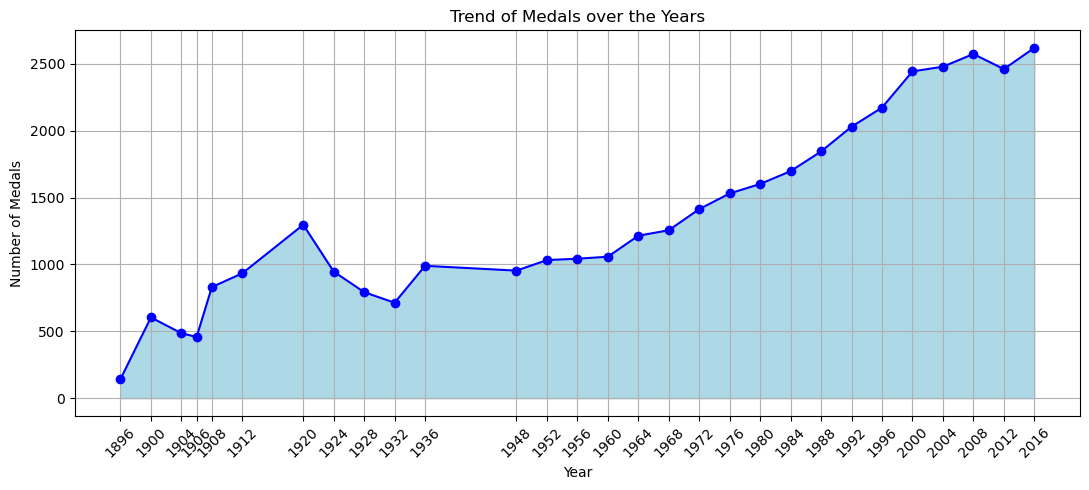

In [10]:
medals_per_year = olympics_data.groupby('Year')['Medal'].count()

#creazione di un grafico per visualizzare l'andamento delle medaglie nel corso degli anni
plt.figure(figsize=(11, 5))
plt.plot(medals_per_year.index, medals_per_year.values, marker='o', color='blue')
plt.fill_between(medals_per_year.index, medals_per_year.values, color='lightblue')

plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.title('Trend of Medals over the Years')

plt.xticks(medals_per_year.index, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Numero di partecipazioni maschili e femminili negli anni

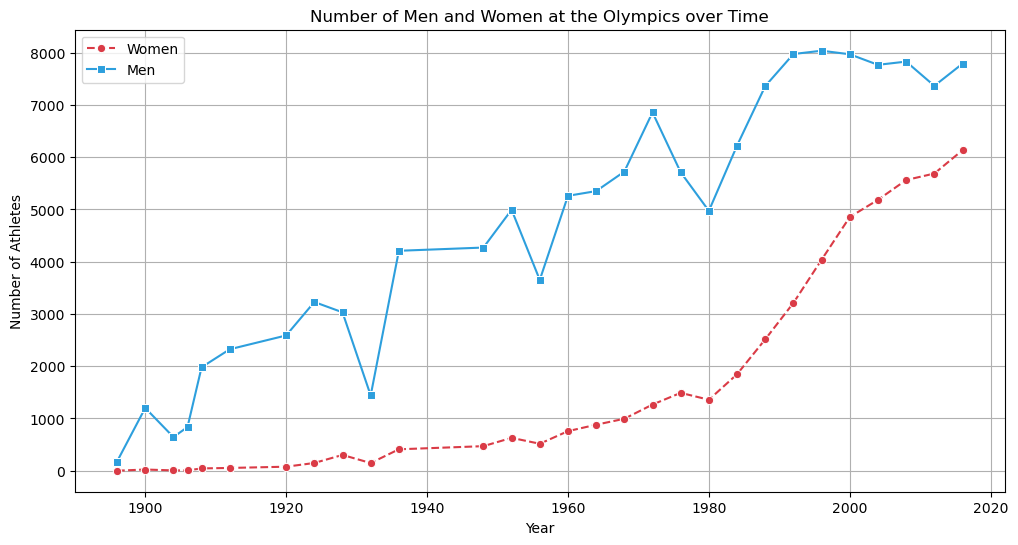

In [12]:
#conteggio del numero di uomini e donne per anno
counts_sex = olympics_data.groupby(['Year', 'Sex'])['ID'].nunique().unstack(fill_value=0)

#creazione del grafico a linee
plt.figure(figsize=(12, 6))

#applicazione di stili diversi per le linee
sns.lineplot(data=counts_sex['F'], label='Women', marker='o', linestyle='--', color='#da3b46')
sns.lineplot(data=counts_sex['M'], label='Men', marker='s', linestyle='-', color='#2d9fdd')
plt.title('Number of Men and Women at the Olympics over Time')
plt.xlabel('Year')
plt.ylabel('Number of Athletes')
plt.grid(True)
plt.show()

# Distribuzione dell'età per genere negli anni

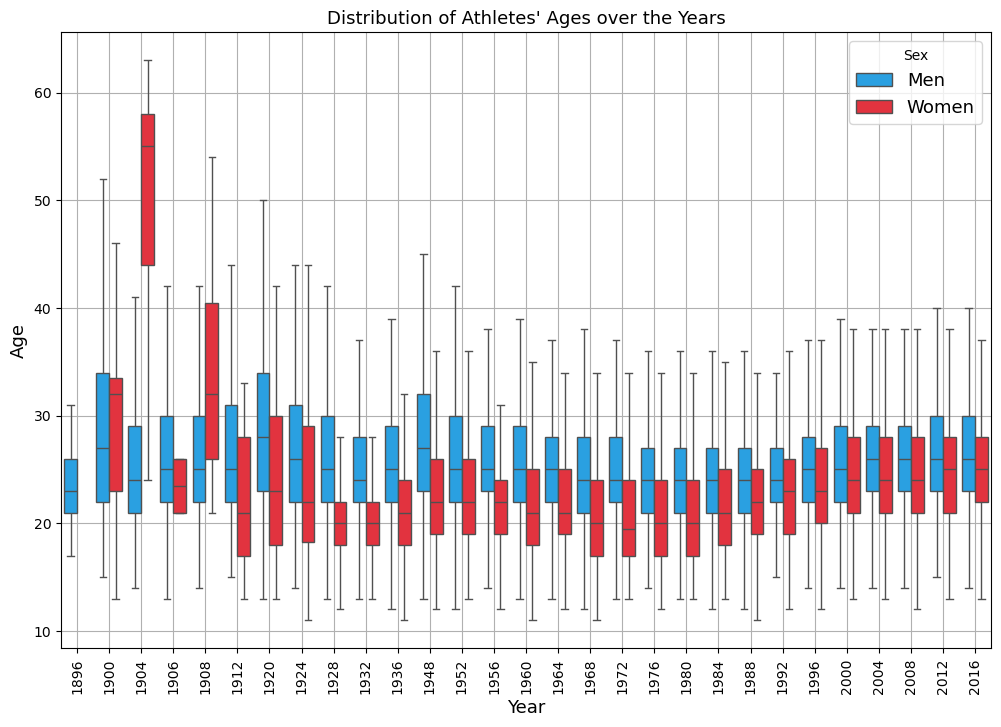

In [14]:
ages = olympics_data.dropna(subset=['Age'])

#creazione del boxplot
plt.figure(figsize=(12, 8))

#definizione della palette di colori per maschi e femmine
colors = {"M": sns.saturate('#2d9fdd'), "F": sns.saturate('#da3b46')}

#visualizzazione della distribuzione dell'età degli atleti negli anni
sns.boxplot(x='Year', y='Age', hue='Sex', data=ages, palette=colors, showfliers=False)

plt.title('Distribution of Athletes\' Ages over the Years', fontsize=13)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Age', fontsize=13)
plt.grid(True)

plt.xticks(rotation=90)

#personalizzazione della legenda
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Men', 'Women'], title='Sex', fontsize=13)

# Distribuzione assoluta d'età

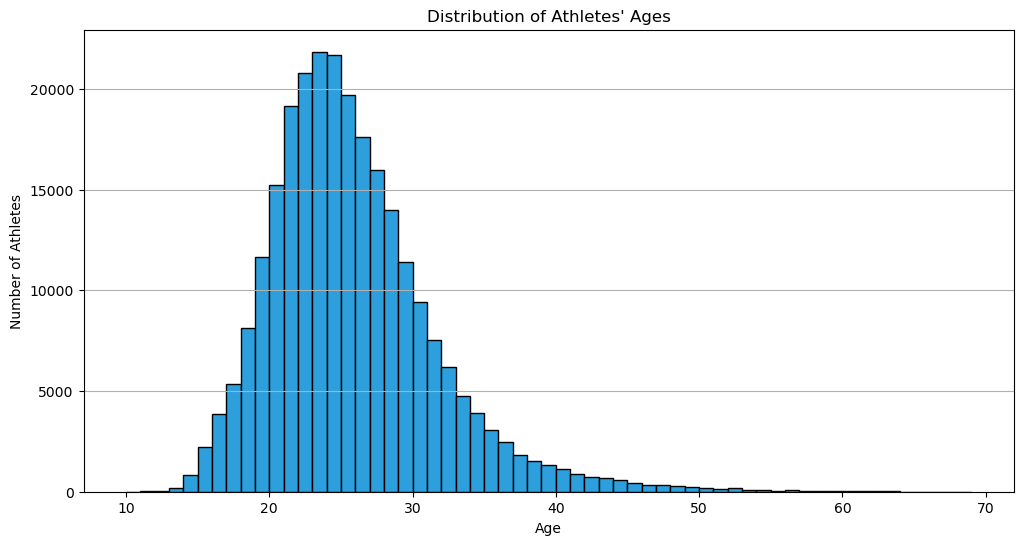

In [16]:
#rimozione delle righe con valori mancanti per le colonne 'Age' e 'Sex'
df_cleaned = olympics_data.dropna(subset=['Age', 'Sex'])

#creazione dell'istogramma per la distribuzione delle età degli atleti
plt.figure(figsize=(12, 6))
plt.hist(df_cleaned['Age'], bins=range(10, 70, 1), edgecolor='black', color='#2d9fdd')
plt.title('Distribution of Athletes\' Ages')
plt.xlabel('Age')
plt.ylabel('Number of Athletes')
plt.grid(axis='y')
plt.show()

# Andamento di performance degli atleti nei 100M basata su genere negli anni

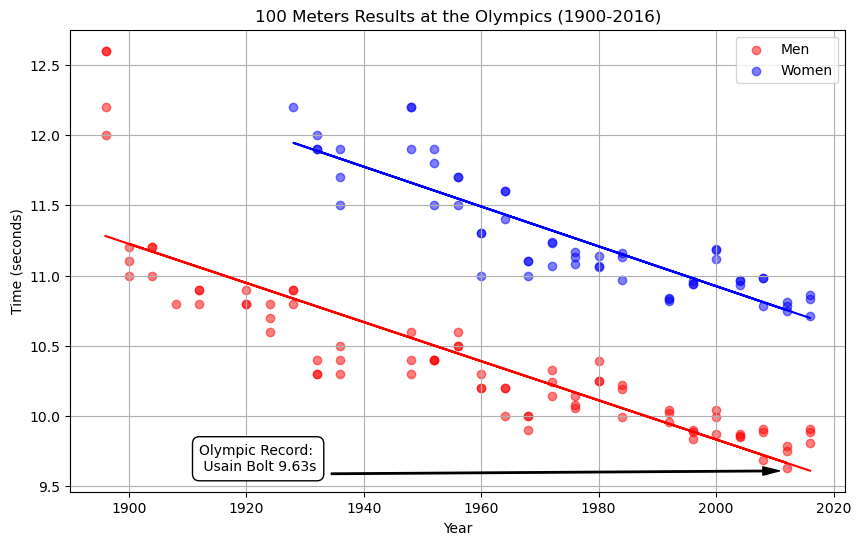

In [18]:
#filtro dei dati per l'evento dei 100 metri sia maschili che femminili
df_100m_men = results_data[results_data['Event'] == '100M Men']
df_100m_women = results_data[results_data['Event'] == '100M Women']

#estrazione delle colonne d'interesse
df_100m_men = df_100m_men[['Year', 'Result']]
df_100m_women = df_100m_women[['Year', 'Result']]

#converte la colonna "Result" in valori numerici
df_100m_men['Result'] = pd.to_numeric(df_100m_men['Result'], errors='coerce')
df_100m_women['Result'] = pd.to_numeric(df_100m_women['Result'], errors='coerce')

#rimozione di eventuali valori NaN (risultati non numerici)
df_100m_men = df_100m_men.dropna()
df_100m_women = df_100m_women.dropna()

#creazione del grafico a dispersione
plt.figure(figsize=(10, 6))
plt.scatter(df_100m_men['Year'], df_100m_men['Result'], color='red', alpha=0.5, label='Men')
plt.scatter(df_100m_women['Year'], df_100m_women['Result'], color='blue', alpha=0.5, label='Women')

#calcolo della retta di regressione per i risultati degli uomini
m, b = np.polyfit(df_100m_men['Year'], df_100m_men['Result'], 1)
plt.plot(df_100m_men['Year'], m*df_100m_men['Year'] + b, color='red')

#calcolo della retta di regressione per i risultati delle donne
m, b = np.polyfit(df_100m_women['Year'], df_100m_women['Result'], 1)
plt.plot(df_100m_women['Year'], m*df_100m_women['Year'] + b, color='blue')

#inserimento label per record olimpionico
min_result_men = df_100m_men['Result'].min()
min_year_men = df_100m_men[df_100m_men['Result'] == min_result_men]['Year'].values[0]

plt.annotate(f'Olympic Record:\n Usain Bolt {min_result_men}s',
             xy=(min_year_men, min_result_men - 0.02), 
             xytext=(min_year_men - 100, min_result_men - 0.02),
             arrowprops=dict(facecolor='black', shrink=0.015, width=1, headwidth=6),
             fontsize=10, color='black', horizontalalignment='left',
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

plt.title('100 Meters Results at the Olympics (1900-2016)')
plt.xlabel('Year')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()